# Clean up for your vacation images

In [300]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [313]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sts

import spring_cleaning as sc # outsourced code

# How many correlations exist between images?

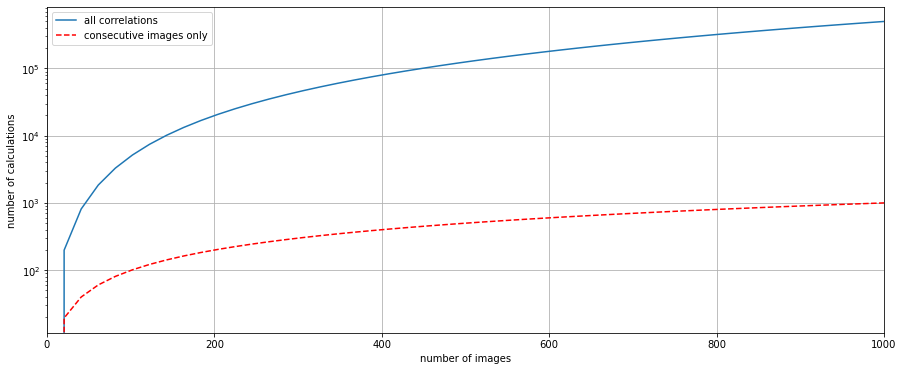

In [3]:
# function increases steeply, thus we make the assumption that only 
# consecutive images are related to each other

def corr(n):
    return n*(n-1)/2

n_max = 1000
n = np.linspace(0, n_max)
plt.figure(figsize=(15, 6))
plt.plot(n, corr(n), label='all correlations')
plt.plot(n, n-1, 'r--', label='consecutive images only')
plt.xlabel('number of images')
plt.ylabel('number of calculations')
plt.grid()
plt.legend()
plt.xlim([0, n_max])
plt.semilogy();

# Pipeline

In [317]:
# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')

df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['creation_date'] = pd.to_numeric(df['creation_date'], downcast='integer')

# For ranking of images, we need some intrinsic measure for consecutiveness
# 'Creation Date' of images is a good measure
# 'File Name' as well, if pictures are taken from one and the same camera

# alternatively, sort by Filename: df.sort_values(by=['File'])
df = df.sort_values(by=['creation_date'])
df['timediff_value'] = df['creation_date'].diff(-1).abs()

# Load images
df['gray_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]

df['hsv_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='hsv')) 
                                            for cur_file in df['file'].values]

df.head()

,file,creation_date,timediff_value,gray_images,hsv_images
23,ar_1.JPG,1487935036,0.0,"[[196, 198, 199, 202, 202, 203, 204, 204, 203,...","[[[116, 34, 219], [116, 33, 221], [116, 33, 22..."
22,ar_0.JPG,1487935036,16.0,"[[196, 199, 199, 201, 203, 204, 204, 205, 205,...","[[[116, 34, 219], [116, 33, 222], [116, 33, 22..."
25,as_1.JPG,1487935052,0.0,"[[193, 192, 191, 190, 190, 190, 190, 189, 187,...","[[[116, 19, 205], [116, 19, 204], [116, 19, 20..."
24,as_0.JPG,1487935052,10.0,"[[194, 194, 193, 191, 190, 190, 191, 189, 189,...","[[[116, 19, 206], [116, 19, 206], [116, 19, 20..."
26,at_0.JPG,1487935062,2.0,"[[201, 198, 197, 198, 196, 195, 194, 192, 192,...","[[[120, 10, 208], [120, 10, 205], [111, 13, 20..."


In [318]:
# Assign labels
df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])
n_img = len(df['target'].unique())

# perfect loss output 
sc.calculate_loss(df['target'], df['target'], n_img)

(20, 20, 1.0)

In [319]:
# Rank by time
# useful, if sequences of images are shot

df['timediff_rank'] = sc.timelag_ranker(df['timediff_value'])

In [337]:
# Rank by image hash

df['hash_value'] = sc.compare_hashes_adv(df['gray_images'], return_hash_only=True)
df['hash_rank'] = sc.hash_ranker(df['hash_value'], HASH_DIM)

df['hash_adv_value'] = sc.compare_hashes_adv(df['gray_images'])
df['hash_adv_rank'] = sc.hash_ranker(df['hash_adv_value'], HASH_DIM, 0.95)

In [338]:
# Rank by correlation of image histograms

df['correl_corr'] = sc.calc_correlations(df['hsv_images'], 'correl')
df['correl_rank'] = sc.corr_ranker(df['correl_corr'])

df['bhattacharyya_corr'] = sc.calc_correlations(df['hsv_images'], 'bhattacharyya')
df['bhattacharyya_rank'] = sc.corr_ranker(df['bhattacharyya_corr'])

In [339]:
# Create ranks from ensemble of previous methods

voting_col = [col for col in df.columns if col.endswith('_rank')]
df['voting_diff'] = df[voting_col].diff(-1).fillna(-1).apply(lambda x: 1 + np.mean(x), axis=1)
df['voting_rank'] = sc.vote_ranker(df['voting_diff'])

# Performance summary - Ranker

In [340]:
evals = {col: sc.calculate_loss(df['target'], df[col], n_img) 
             for col in voting_col + ['voting_rank', 'target']
}
df_eval = pd.DataFrame.from_dict(evals, orient='index', 
            columns=['groups_found', 'groups_unique', 'loss']).sort_values(
            by=['loss'])

df_eval

,groups_found,groups_unique,loss
target,20,20,1.00
bhattacharyya_rank,20,22,2.35
voting_rank,20,22,2.55
correl_rank,20,22,2.85
timediff_rank,20,21,3.85
hash_adv_rank,20,26,19.50
hash_rank,20,28,30.50


Text(0.5, 1.0, 'Images identified by different ranking methods\n')

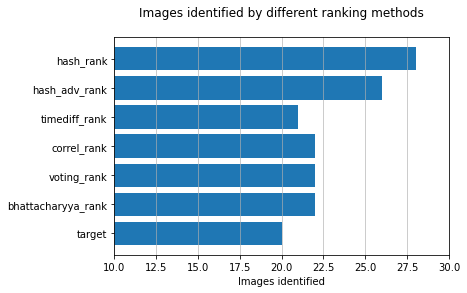

In [341]:
plt.barh(df_eval.index, df_eval['groups_unique'])
plt.xlim([10, 30])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Images identified')
plt.title('Images identified by different ranking methods\n')

Text(0.5, 1.0, 'Loss of different ranking methods\n')

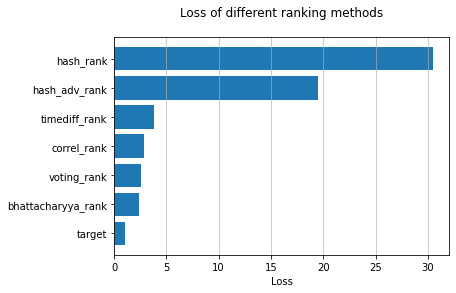

In [342]:
plt.barh(df_eval.index, df_eval['loss'])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Loss')
plt.title('Loss of different ranking methods\n')

# Identify the best images: high-pass filtering

In [327]:
df['magnitude_spectrum'] = [sc.high_pass_filtering(img) for img in gray_images]

# Alternatively:
#df['gray_images'] = gray_images
#df['Magnitude_spectrum'] = df['gray_images'].apply(lambda x: sc.high_pass_filtering(x))
#df.drop(['gray_images'], axis=1, inplace=True)

In [328]:
df.head()

,file,creation_date,timediff_value,gray_images,hsv_images,target,timediff_rank,hash_value,hash_rank,hash_adv_value,hash_adv_rank,correl_corr,correl_rank,bhattacharyya_corr,bhattacharyya_rank,voting_diff,voting_rank,magnitude_spectrum
23,ar_1.JPG,1487935036,0.0,"[[196, 198, 199, 202, 202, 203, 204, 204, 203,...","[[[116, 34, 219], [116, 33, 221], [116, 33, 22...",0,0,64,0,64,0,0.993338,0,0.715417,0,1.0,0,15402.089169
22,ar_0.JPG,1487935036,16.0,"[[196, 199, 199, 201, 203, 204, 204, 205, 205,...","[[[116, 34, 219], [116, 33, 222], [116, 33, 22...",0,0,57,0,64,0,0.326386,0,0.412917,0,0.2,0,16254.045967
25,as_1.JPG,1487935052,0.0,"[[193, 192, 191, 190, 190, 190, 190, 189, 187,...","[[[116, 19, 205], [116, 19, 204], [116, 19, 20...",1,1,64,1,64,0,0.996549,1,0.742164,1,1.0,1,14003.057989
24,as_0.JPG,1487935052,10.0,"[[194, 194, 193, 191, 190, 190, 191, 189, 189,...","[[[116, 19, 206], [116, 19, 206], [116, 19, 20...",1,1,57,1,58,0,0.501313,1,0.440976,1,0.0,1,16545.822903
26,at_0.JPG,1487935062,2.0,"[[201, 198, 197, 198, 196, 195, 194, 192, 192,...","[[[120, 10, 208], [120, 10, 205], [111, 13, 20...",2,2,64,2,64,1,0.996458,2,0.760585,2,1.0,2,12763.647863


# Apply results

In [15]:
# Finally, copy the images into ready-to-go directory, that's it!

sc.copy_images(df, (IMAGES, IMAGES_PROCESSED), 'voting_rank', 'magnitude_spectrum')

# Hereafter: WIP

# Deep-dive: Hashing

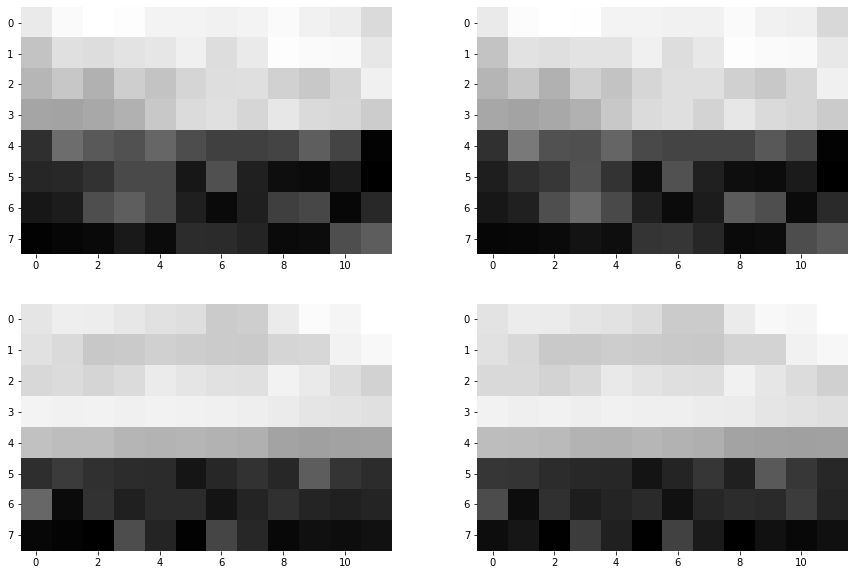

In [329]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[0]), cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[1]), cmap='gray')
plt.subplot(223, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[2]), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.hash_image(df['gray_images'].iloc[3]), cmap='gray')

# Rotate

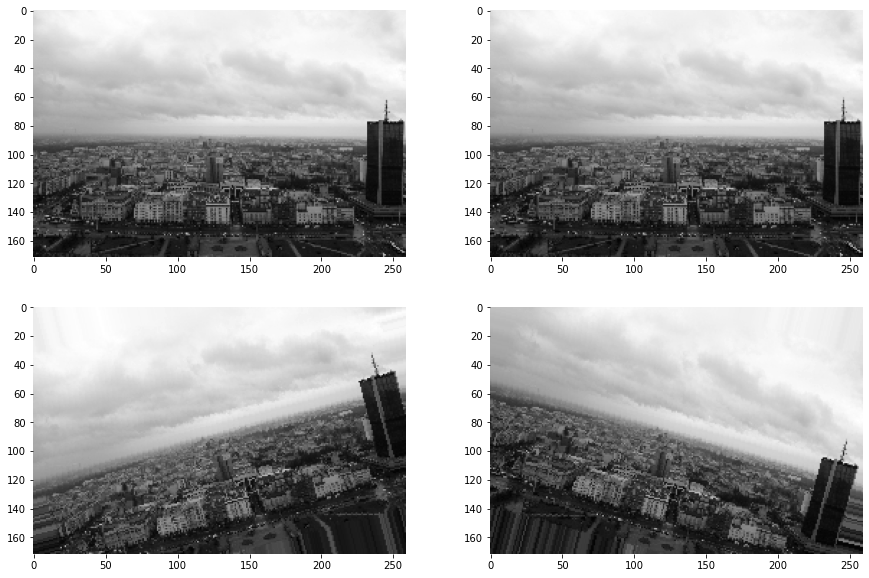

In [330]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(df['gray_images'].iloc[0], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(df['gray_images'].iloc[1], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.rotate_img(df['gray_images'].iloc[1], 15), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.rotate_img(df['gray_images'].iloc[1], -15), cmap='gray')

# Warp images

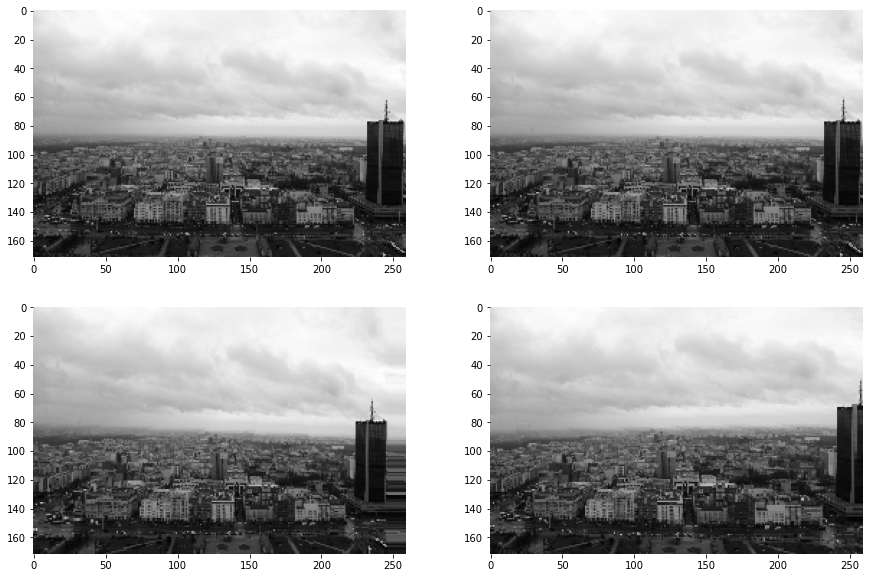

In [331]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(df['gray_images'].iloc[0], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(df['gray_images'].iloc[1], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.warp_img(df['gray_images'].iloc[1], 0.05, how='left'), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.warp_img(df['gray_images'].iloc[1], 0.05, how='right'), cmap='gray')

# Find default values for limits

In [332]:
def bootstrap_data(df, n_runs=10):
    """
    #TODO: DOCSTRING
    """
    true_targets = df['target'].copy()
    targets = np.arange(0, len(true_targets.unique()))

    runs = []
    for i in range(n_runs):
        np.random.seed(i)
        new_targets = np.random.choice(targets, size=len(targets), replace=False)
        
        # add some "randomness" by reversing images of each group
        if i % 2 == 0:
            df.sort_values(['creation_date'], inplace=True)
        else:
            df.sort_values(['creation_date'], ascending=False, inplace=True)
            
        df['target'] = true_targets.map(dict(zip(targets, new_targets)))
        df.sort_values(['target'], inplace=True)
        
        df['hash_value'] = sc.compare_hashes_adv(df['gray_images'].tolist(),
                                                 return_hash_only=True)
        df['correl_corr'] = sc.calc_correlations(df['hsv_images'].tolist(),
                                                 'correl')
        df['bhattacharyya_corr'] = sc.calc_correlations(df['hsv_images'].tolist(), 
                                                'bhattacharyya')
        
        runs.append(df[['target', 'creation_date', 
                        'hash_value', 'correl_corr', 'bhattacharyya_corr']])
    return runs

def return_distribution(data, _type=None, target_col=None, comp_col=None):
    """
    #TODO: DOCSTRING
    """
    if _type == 'first':
        firsts = []
        for cur_res in res:
            #TODO: calculate mean of element [0,n-1] if group size > 2
            rel_rows = (cur_res.groupby([target_col])[comp_col].agg('count') > 1).values
            firsts.append(cur_res.groupby([target_col])[comp_col].first().iloc[rel_rows])
        firsts = np.sort(np.array(firsts).reshape(-1))
        return firsts
    
    elif _type == 'last':
        lasts = np.sort(np.array([cur_res.groupby([target_col])[comp_col].last().values 
                  for cur_res in data]).reshape(-1))
        return lasts
    
def plot_distributions(dfirst, dlast, bins=10, labels=('x', 'y'), title=''):
    """
    #TODO: DOCSTRING
    """
    xmin, xmax = min(np.append(dfirst, dlast)), max(np.append(dfirst, dlast))
    margin = (xmax-xmin)*0.1
    xrange = np.arange(xmin - margin*2, xmax + margin*2, 0.01)
        
    plt.figure(figsize=(10, 5))
    kde_first = sts.gaussian_kde(dfirst)
    plt.hist(dfirst, bins=bins, rwidth=0.9, density=True, label='first', color='gold', alpha=0.7);
    plt.plot(xrange, kde_first(xrange), lw=2, ls='-', color='#6666ff', label='first-KDE')

    kde_last = sts.gaussian_kde(dlast)
    plt.hist(dlast, bins=bins, rwidth=0.9, density=True, label='last', color='gray', alpha=0.7);
    plt.plot(xrange, kde_last(xrange), lw=2, ls='-', color='#ff6666', label='last-KDE')
    
    plt.xlim([xmin - margin*2, xmax + margin*2])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    
def calculate_confusion_matrix(dfirst, dlast, add_std=False):
    """
    #TODO: DOCSTRING
    """
    limit = dfirst.mean()
    if add_std is True:
        limit += dfirst.std()
        
    tp = sum([1 for c in dfirst if c >= limit])
    fn = len(dfirst) - tp
    tn = sum([1 for c in dlast if c < limit])
    fp = len(dlast) - tn

    print('True positive: {} -- False negative: {}'.format(tp, fn))
    print('True negative: {} -- False positive: {}'.format(tn, fp))

In [348]:
res = shuffle_data(df, n_runs=10)

# For Hashing

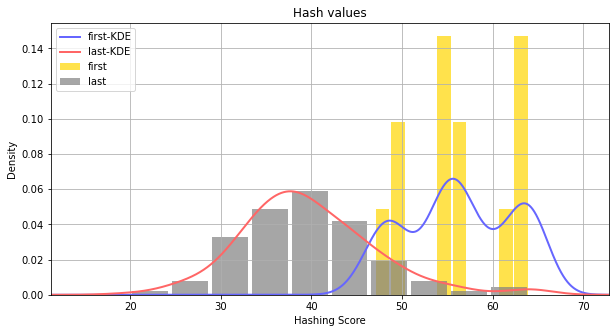

Mean value for groups: 56.33 +- 5.79
Mean value for non-groups: 39.63 +- 7.43


In [349]:
lasts = return_distribution(res, _type='last', target_col='target', comp_col='hash_value')
firsts = return_distribution(res, _type='first', target_col='target', comp_col='hash_value')

plot_distributions(firsts, lasts, labels=('Hashing Score', 'Density'), title='Hash values')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(firsts.mean(), firsts.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}'.format(lasts.mean(), lasts.std()))

In [350]:
calculate_confusion_matrix(firsts, lasts)

True positive: 60 -- False negative: 60
True negative: 194 -- False positive: 6


In [351]:
calculate_confusion_matrix(firsts, lasts, add_std=True)

True positive: 30 -- False negative: 90
True negative: 196 -- False positive: 4


# For Bhattacharyya correlation

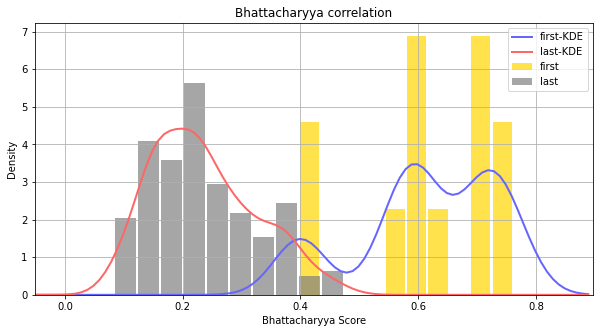

Mean value for groups: 0.61 +- 0.12
Mean value for non-groups: 0.24 +- 0.09


In [352]:
lasts_corr = return_distribution(res, _type='last', target_col='target', comp_col='bhattacharyya_corr')
firsts_corr = return_distribution(res, _type='first', target_col='target', comp_col='bhattacharyya_corr')

plot_distributions(firsts_corr, lasts_corr, labels=('Bhattacharyya Score', 'Density'),
                   title='Bhattacharyya correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(firsts_corr.mean(), firsts_corr.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}'.format(lasts_corr.mean(), lasts_corr.std()))

In [353]:
calculate_confusion_matrix(firsts_corr, lasts_corr)

True positive: 60 -- False negative: 60
True negative: 200 -- False positive: 0


In [354]:
calculate_confusion_matrix(firsts_corr, lasts_corr, add_std=True)

True positive: 20 -- False negative: 100
True negative: 200 -- False positive: 0


# For Correlation

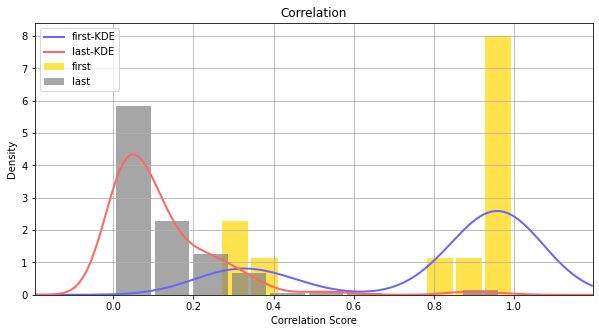

Mean value for groups: 0.80 +- 0.27
Mean value for non-groups: 0.12 +- 0.14


In [355]:
lasts_corr2 = return_distribution(res, _type='last', target_col='target', comp_col='correl_corr')
firsts_corr2 = return_distribution(res, _type='first', target_col='target', comp_col='correl_corr')

plot_distributions(firsts_corr2, lasts_corr2, labels=('Correlation Score', 'Density'),
                   title='Correlation')

print('Mean value for groups: {:.2f} +- {:.2f}'.format(firsts_corr2.mean(), firsts_corr2.std()))
print('Mean value for non-groups: {:.2f} +- {:.2f}'.format(lasts_corr2.mean(), lasts_corr2.std()))

In [356]:
calculate_confusion_matrix(firsts_corr2, lasts_corr2)

True positive: 90 -- False negative: 30
True negative: 197 -- False positive: 3


In [357]:
calculate_confusion_matrix(firsts_corr2, lasts_corr2, add_std=True)

True positive: 0 -- False negative: 120
True negative: 200 -- False positive: 0


In [279]:
#TODO: Make a Logistic regression fit instead of using mean value as limit

----------------------------------------------------------------------------------------------------------------------

# hereafter: WIP

# Evaluate Advanced Hashing

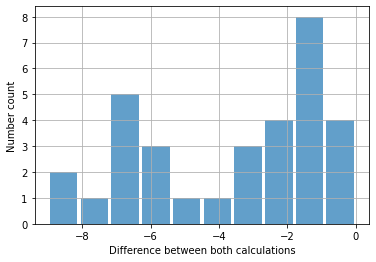

In [292]:
# two groups can be identified: small & larger differences
# small differences seem to be caused by better matching of similar images
# larger differences are rather errorneous correlations
# -> can be used as believable max_change

df['hash_diff'] = df['hash_value'] - df['hash_adv_value']

plt.hist((df['hash_value'] - df['hash_adv_value']), bins=10, rwidth=0.9, alpha=0.7);
plt.xlabel('Difference between both calculations')
plt.ylabel('Number count')
plt.grid()

# Deep-dive: high-pass filtering

In [ ]:
grouped = df.groupby(['target']).agg(mag_mean=('magnitude_spectrum', np.mean),
            mag_std=('magnitude_spectrum', np.std))

grouped = grouped.loc[grouped['mag_std'].notna(), :]
grouped.head()